# 1. CÀI ĐẶT THƯ VIỆN

In [1]:
import pandas as pd
import scipy
import sklearn
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

# 2. ĐỌC VÀ TIỀN XỬ LÝ DỮ LIỆU

In [2]:
df = pd.read_csv("gold_price.csv")
df.columns = ["Date", "Price", "Open", "High", "Low", "Volume", "Change"]
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df = df.sort_values("Date").reset_index(drop=True)
for col in ["Price", "Open", "High", "Low"]:
    df[col] = df[col].str.replace(",", "").astype(float)
df["Volume"] = df["Volume"].str.replace("K", "").str.replace(",", "").astype(float) * 1_000
df["Change"] = df["Change"].str.replace("%", "").astype(float)

# 3. TẠO DỮ LIẸU GIẢI QUYẾT VỚI TIMESTEP = 90

In [3]:
def create_supervised(data, features, target, timesteps=90):
    X, y, dates = [], [], []
    for i in range(timesteps, len(data)):
        window = data[features].iloc[i-timesteps:i].values.flatten()
        X.append(window)
        y.append(data[target].iloc[i])
        dates.append(data["Date"].iloc[i])
    cols = [f"{feat}_lag{lag}" for lag in range(timesteps, 0, -1) for feat in features]
    df_sup = pd.DataFrame(np.array(X), columns=cols)
    df_sup["target"] = y
    df_sup["Date"] = dates
    return df_sup

features = ["Open", "High", "Low", "Volume", "Change"]
target = "Price"
df_sup = create_supervised(df, features, target, timesteps=90)

# 4. CHUẢN HOÁ DỮ LIỆU

In [4]:
scaler = StandardScaler()
X_all = df_sup.drop(["target", "Date"], axis=1)
y_all = df_sup["target"]
X_scaled = scaler.fit_transform(X_all)

# 5. CHIA TẬP TRAIN/VAL/TEST (70/15/15)

In [5]:
n = len(X_scaled)
train_end = int(n * 0.6)
val_end = train_end + int(n * 0.2)

dates = df_sup["Date"]
dates_train = dates.iloc[:train_end]
dates_val   = dates.iloc[train_end:val_end]
dates_test  = dates.iloc[val_end:]

X_train, y_train = X_scaled[:train_end], y_all.iloc[:train_end]
X_val, y_val     = X_scaled[train_end:val_end], y_all.iloc[train_end:val_end]
X_test, y_test   = X_scaled[val_end:], y_all.iloc[val_end:]

# 6. HUẤN LUYỆN MÔ HÌNH

In [6]:
model = LGBMRegressor(
    objective='regression',
    learning_rate=0.1,
    n_estimators=1000,
    verbose=-1
)
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=100)]
)

Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 81.1658	valid_0's l2: 6587.89
Early stopping, best iteration is:
[115]	valid_0's rmse: 81.1465	valid_0's l2: 6584.76


LGBMRegressor(n_estimators=1000, objective='regression', verbose=-1)

# 7. DỰ ĐOÁN VÀ ĐÁNH GIÁ (RMSE, MAE, MAPE, MASE)

In [7]:
def evaluate(y_true, y_pred, y_train_series):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    naive = np.abs(y_train_series.values[1:] - y_train_series.values[:-1])
    mase = mae / np.mean(naive)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, mape, mase, r2

y_pred_test = model.predict(X_test)
metrics_test = evaluate(y_test, y_pred_test, y_train)
print(f"Test: RMSE={metrics_test[0]:.4f}, MAE={metrics_test[1]:.4f}, MAPE={metrics_test[2]:.4f}, MASE={metrics_test[3]:.4f}")

Test: RMSE=516.5949, MAE=374.7988, MAPE=0.1546, MASE=39.1121


/Users/nhxtrxng/Desktop/PTDLKD/LGBM/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


# 8. DỰ ĐOÁN TƯƠNG LAI SAU TẬP TEST (30/60/90 ngày)

In [8]:
def forecast_future(window, model, days, feature_cols):
    preds, dates_f = [], []
    start = dates_test.max()
    future_window = window.copy()
    for i in range(1, days+1):
        df_input = pd.DataFrame(future_window, columns=feature_cols)
        pred = model.predict(df_input)[0]
        preds.append(pred)
        dates_f.append(start + pd.Timedelta(days=i))
        # shift and add noise
        future_window = np.roll(future_window, -len(feature_cols))
        future_window[0, -len(feature_cols):] = pred
        future_window = future_window + np.random.normal(0, 0.02, future_window.shape)
    return pd.DataFrame({"ds": dates_f, "pred": preds})

# Define feature columns for forecasting
feature_cols = X_all.columns.tolist()
# Lấy window cuối của tập test (1 x n_features)
last_window = X_test[-1:].copy()

# Forecast with correct signature
future_30_df = forecast_future(last_window, model, 30, feature_cols)
future_60_df = forecast_future(last_window, model, 60, feature_cols)
future_90_df = forecast_future(last_window, model, 90, feature_cols)

# 9. VẼ KẾT QUẢ

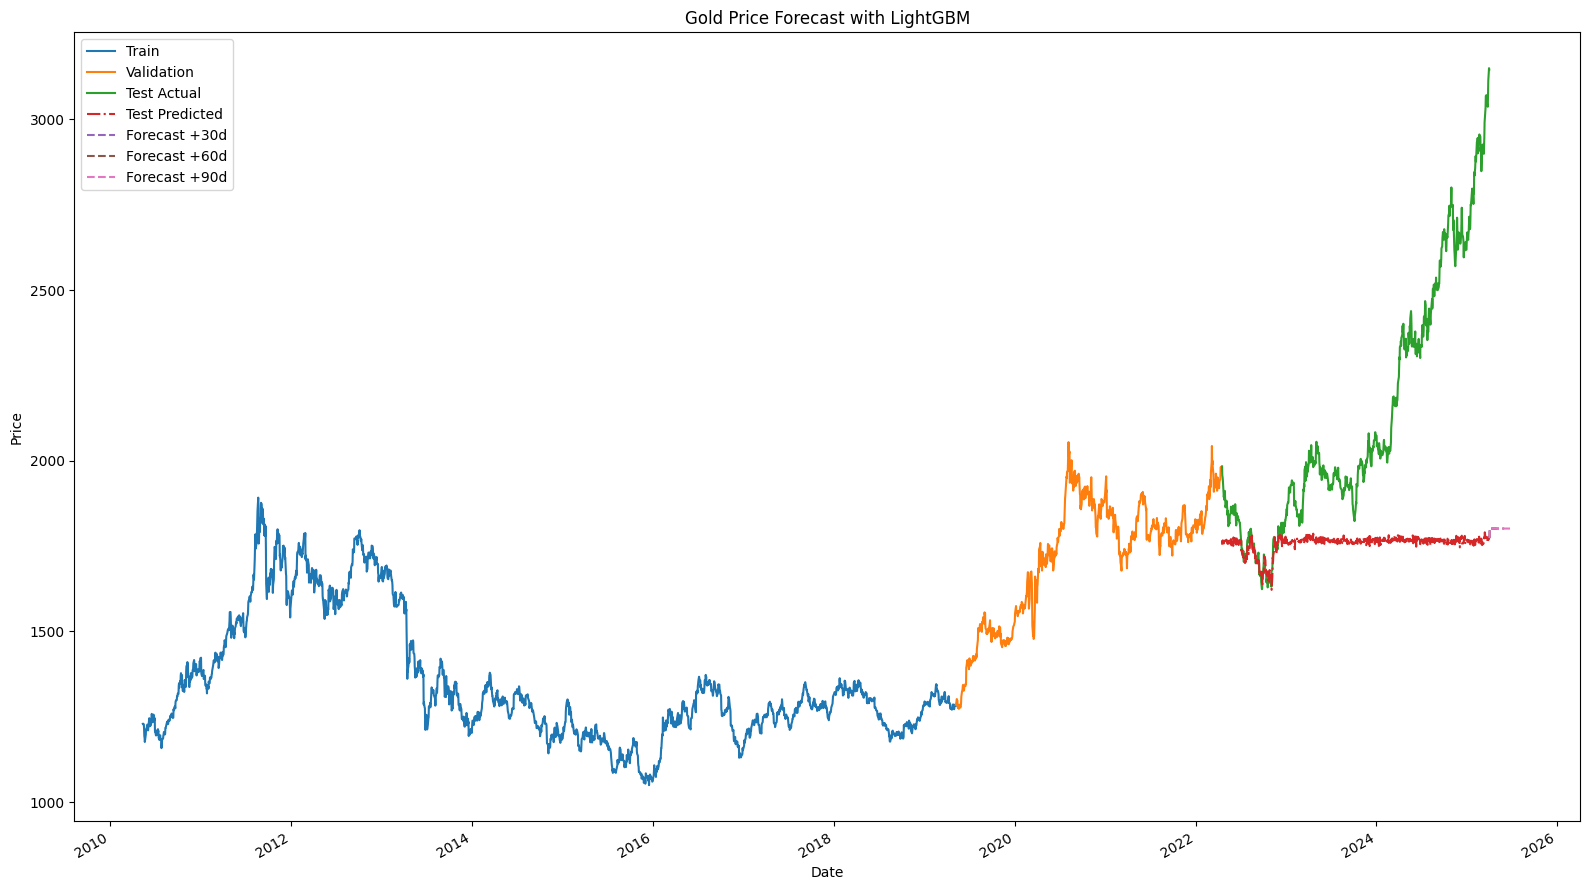

In [9]:
plt.figure(figsize=(16, 9))
# Plot train, validation, test actuals
plt.plot(dates_train, y_train, label="Train")
plt.plot(dates_val, y_val, label="Validation")
plt.plot(dates_test, y_test, label="Test Actual")
# Plot test predictions
plt.plot(dates_test, y_pred_test, label="Test Predicted", linestyle='-.')
# Plot future forecasts
plt.plot(future_30_df["ds"], future_30_df["pred"], label="Forecast +30d", linestyle='--')
plt.plot(future_60_df["ds"], future_60_df["pred"], label="Forecast +60d", linestyle='--')
plt.plot(future_90_df["ds"], future_90_df["pred"], label="Forecast +90d", linestyle='--')

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Gold Price Forecast with LightGBM")
plt.legend()
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()